In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread, imshow
import threading


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Constant

In [ ]:
IMG_SIZE = 48
base = '/content/drive/MyDrive/ashraful/MP'
dataset_dir = "/content/drive/MyDrive/ashraful/MP/new-model"

model_dir = "/content/drive/MyDrive/ashraful/MP/new-model/model.h5"

# Dataset creation

In [ ]:

# import matplotlib.pyplot as plt
# %matplotlib inline
# image_gray = imread('images.jpeg', as_gray=True)
# imshow(image_gray)

dataset_base = "/content/drive/MyDrive/ashraful/MP/mrlEyes_2018_01/mrlEyes_2018_01"
data = []
labels = []
lock = threading.Lock()

def collect_image_in_thread(dir):
    for image_path in os.listdir(dataset_base + '/' +dir):
        # print(image_path)
        label = int(image_path.split("_")[4])
        # print(label)
        try:
            img_array = imread(dataset_base + '/' +dir + '/'+image_path)
            resized_array = resize(img_array, (IMG_SIZE, IMG_SIZE))
            # print(resized_array.shape)
            lock.acquire()
            try:
                if resized_array.shape == (IMG_SIZE, IMG_SIZE):
                    data.append(resized_array)
                    labels.append(label)
                
            except Exception as e2:
                print(e2)
            lock.release()
            # break
        except Exception as e:
            print(e)

def prepare_dataset():
    dirs = os.listdir(dataset_base)
    thread_list = []
    for dir in dirs:
        if dir.startswith("s0"):
            print(dir)
            thread = threading.Thread(target=collect_image_in_thread, args=(dir,))
            thread_list.append(thread)
            thread.start()
    for thread in thread_list:
        thread.join()
    return np.array(data), np.array(labels)

X, y = prepare_dataset()
X = X / 255

with open(dataset_dir + '/X.np', mode='wb') as file:
    np.save(file, X)
with open(dataset_dir + '/y.np', mode='wb') as file:
    np.save(file, y)

print(X.shape)
print(y.shape)

# train validation test split

In [ ]:
# Loading data
with open(dataset_dir + '/X.np', mode='rb') as file:
    X = np.load(file)
with open(dataset_dir + '/y.np', mode='rb') as file:
    y = np.load(file)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 0
X_train, X2, y_train, y2 = train_test_split(X, y, random_state=seed, test_size=0.40)
X_val, X_test, y_val, y_test = train_test_split(X2, y2, random_state=seed, test_size=0.50)

X_train = np.reshape(X_train, (X_train.shape[0], IMG_SIZE, IMG_SIZE, 1))
X_val = np.reshape(X_val, (X_val.shape[0], IMG_SIZE, IMG_SIZE, 1))
X_test = np.reshape(X_test, (X_test.shape[0], IMG_SIZE, IMG_SIZE, 1))

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(109774, 48, 48, 1)
(109774,)
(36591, 48, 48, 1)
(36591,)
(36592, 48, 48, 1)
(36592,)


# Saving data

In [ ]:
with open(dataset_dir + '/X_train.np', mode='wb') as file:
    np.save(file, X_train)
with open(dataset_dir + '/X_val.np', mode='wb') as file:
    np.save(file, X_val)
with open(dataset_dir + '/X_test.np', mode='wb') as file:
    np.save(file, X_test)
with open(dataset_dir + '/y_train.np', mode='wb') as file:
    np.save(file, y_train)
with open(dataset_dir + '/y_val.np', mode='wb') as file:
    np.save(file, y_val)
with open(dataset_dir + '/y_test.np', mode='wb') as file:
    np.save(file, y_test)

# Retrieve Data

In [ ]:
with open(dataset_dir + '/X_train.np', mode='rb') as file:
    X_train = np.load(file)
with open(dataset_dir + '/X_val.np', mode='rb') as file:
    X_val = np.load(file)
with open(dataset_dir + '/X_test.np', mode='rb') as file:
    X_test = np.load(file)
with open(dataset_dir + '/y_train.np', mode='rb') as file:
    y_train = np.load(file)
with open(dataset_dir + '/y_val.np', mode='rb') as file:
    y_val = np.load(file)
with open(dataset_dir + '/y_test.np', mode='rb') as file:
    y_test = np.load(file)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(109774, 48, 48, 1)
(109774,)
(36591, 48, 48, 1)
(36591,)
(36592, 48, 48, 1)
(36592,)


In [ ]:
print("Total Train data (cleased eye)", sum(y_train == 0))
print("Total Train data (open eye)", sum(y_train == 1))
print("Total Train data", len(y_train))

print("Total Validation data (cleased eye)", sum(y_val == 0))
print("Total Validation data (open eye)", sum(y_val == 1))
print("Total Validation data", len(y_val))

print("Total Test data (cleased eye)", sum(y_test == 0))
print("Total Test data (open eye)", sum(y_test == 1))
print("Total Test data", len(y_test))

print("Total data", len(y_train) + len(y_val) + len(y_test))

Total Train data (cleased eye) 58923
Total Train data (open eye) 50851
Total Train data 109774
Total Validation data (cleased eye) 19694
Total Validation data (open eye) 16897
Total Validation data 36591
Total Test data (cleased eye) 19475
Total Test data (open eye) 17117
Total Test data 36592
Total data 182957


# Model

In [ ]:
# Best
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu",
        input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(3, 3))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(3, 3))

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="tanh"))

model.compile(loss="binary_crossentropy",
            metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)              

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20, 
                    batch_size=64)


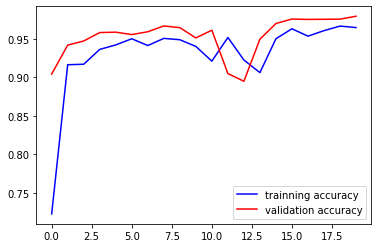

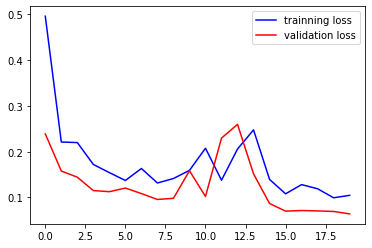

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()


In [ ]:
prediction = model.predict(X_test)
prediction = (prediction > 0) * 1

labels = ["Closed", "Open"]

from sklearn.metrics import classification_report
print(classification_report(y_test, prediction, target_names=labels))

model.evaluate(x=X_test, y=y_test)

              precision    recall  f1-score   support

      Closed       1.00      0.84      0.91     19475
        Open       0.85      1.00      0.92     17117

    accuracy                           0.92     36592
   macro avg       0.92      0.92      0.92     36592
weighted avg       0.93      0.92      0.92     36592

1144/1144 [==============================] - 3s 3ms/step - loss: 0.0639 - accuracy: 0.9785


[0.06388749927282333, 0.9784652590751648]

# Model save and retrieve

In [ ]:
# Saving
model.save(model_dir)

In [ ]:
# Retrieving
model = tf.keras.models.load_model(model_dir)

In [ ]:
model.evaluate(x=X_test, y=y_test)

1144/1144 [==============================] - 3s 3ms/step - loss: 0.0639 - accuracy: 0.9785


[0.06388749927282333, 0.9784652590751648]

# Model Prediction

In [ ]:
model_dir = "/content/drive/MyDrive/ashraful/MP/new-model/model.h5"
labels = ["Closed", "Open"]
IMG_SIZE = 48

model = tf.keras.models.load_model(model_dir)
model.summary()

def prepare(filepath):
    img_array = imread(filepath)
    print(img_array.shape)
    resized_array = resize(img_array, (1, IMG_SIZE, IMG_SIZE, 1))
    resized_array = resized_array / 255
    print(resized_array.shape)
    return resized_array

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 15, 15, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 13, 13, 32)        18464     
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 4, 4, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_51 (Flatten)        (None, 512)               0         
                                                                 
 dropout_98 (Dropout)        (None, 512)             

In [ ]:
def predict(filepath):
    prediction = model.predict(prepare(filepath))
    return labels[((prediction > 1)*0)[0][0]]

(87, 87)
(1, 48, 48, 1)
Prediction Closed
Time 0.047602176666259766


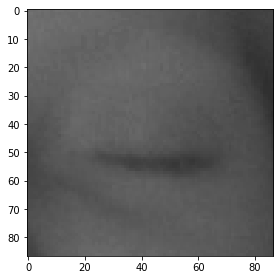

In [ ]:
start = time.time()
image_path = "/content/drive/MyDrive/ashraful/MP/mrlEyes_2018_01/mrlEyes_2018_01/s0017/s0017_00001_1_0_0_0_0_01.png"
prediction = predict(image_path)
end = time.time()

print("Prediction", prediction)
print("Time", end-start)

imshow(image_path)